# Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Загрузка данных

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")

# Первичный анализ данных

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

В данных отсутствуют пропущенные значения, что упрощает процесс подготовки данных. Благодаря этому мы можем сразу перейти к кодированию признаков — бинарные категории преобразуем с помощью словаря и метода .map(), а мультикатегориальные признаки — с помощью OneHot-кодирования (pd.get_dummies()). Такой подход позволит корректно подготовить данные для дальнейшего анализа и построения моделей.

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


В данных всего 3 числовых признака, поэтому остальные 18 признаков являются категориальными. Следовательно, для дальнейшей работы с этими данными потребуется выполнить кодирование категориальных признаков.

In [6]:
df['TotalCharges']=df['TotalCharges'].replace(" ","0")
df['TotalCharges']=df['TotalCharges'].astype("float")

In [7]:
df = df.drop('customerID',axis=1)

## Анализ целевого признака Churn

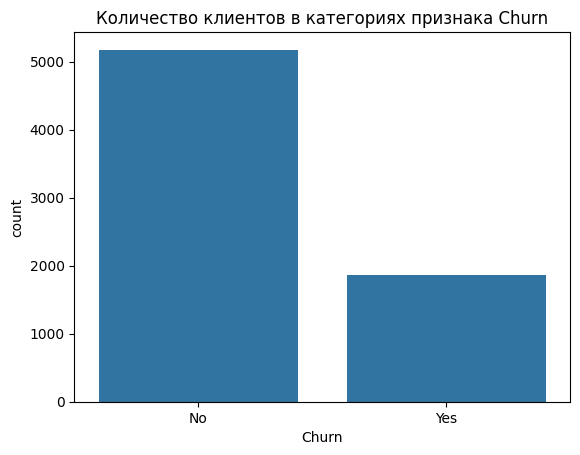

In [8]:
sns.countplot(x=df['Churn'],data=df)
plt.title("Количество клиентов в категориях признака Churn");

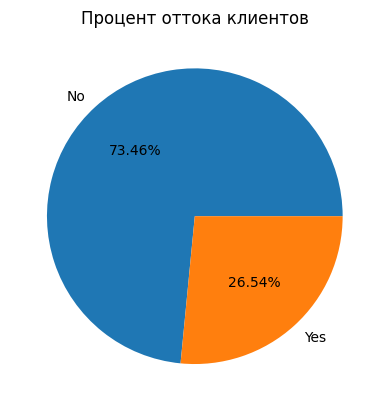

In [9]:
gb = df.groupby('Churn').agg({'Churn': 'count'})
plt.title('Процент оттока клиентов')
plt.pie(gb['Churn'],labels=gb.index,autopct='%1.2f%%');

**Общий уровень оттока:**
* 26.54% клиентов уходят (высокий показатель, требующий внимания).
* 73.46% клиентов остаются, что говорит о стабильной клиентской базе.

**Ключевые выводы по оттоку клиентов:**
1. Проблема: Каждый четвертый клиент прекращает обслуживание.
2. Возможность: Улучшение удержания даже части этих клиентов может значительно повысить прибыль.
3. Фокус: Необходимо выявить причины оттока и внедрить таргетированные стратегии удержания.

## Анализ признака gender

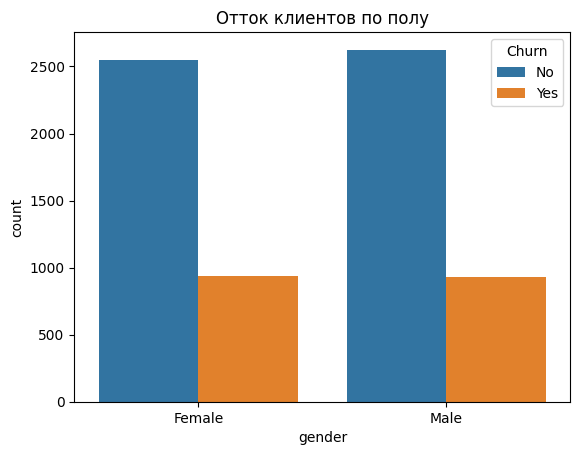

In [10]:
sns.countplot(x=df['gender'],data=df,hue='Churn')
plt.title('Отток клиентов по полу');

## Анализ признака SeniorCitizen

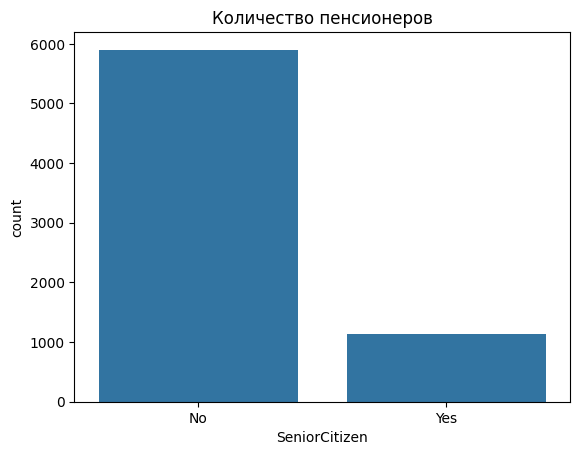

In [11]:
sns.countplot(x=df['SeniorCitizen'].map({0:'No', 1:'Yes'}),data=df)
plt.title('Количество пенсионеров');

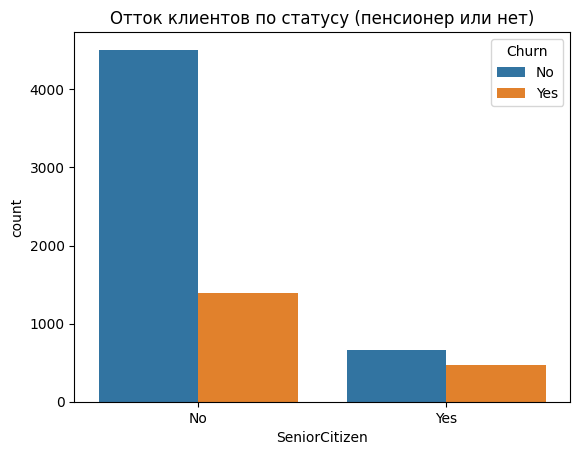

In [12]:
sns.countplot(x=df['SeniorCitizen'].map({0:'No', 1:'Yes'}),data=df,hue='Churn')
plt.title('Отток клиентов по статусу (пенсионер или нет)');

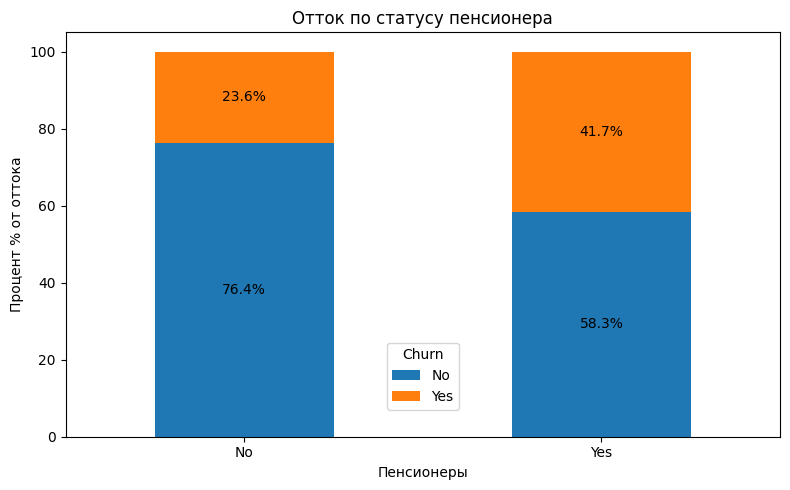

In [13]:
counts = df.groupby(['SeniorCitizen','Churn']).size().unstack()
percentages = counts.div(counts.sum(axis=1),axis=0) * 100

ax = percentages.plot(kind='bar', stacked=True, figsize=(8, 5))

for idx, row in percentages.iterrows():
    y_offset = 0
    for col in percentages.columns:
        pct = row[col]
        if pct > 0:
            ax.text(idx, y_offset + pct / 2, f'{pct:.1f}%', ha='center', va='center', color='black', fontsize=10)
        y_offset += pct
        
ax.set_xticklabels(['No', 'Yes'], rotation=0)
plt.title('Отток по статусу пенсионера')
plt.xlabel('Пенсионеры')
plt.ylabel('Процент % от оттока')
plt.legend(title='Churn', loc='center', bbox_to_anchor=(0.5, 0.15))
plt.xticks(rotation=0)
plt.tight_layout();

**Ключевые показатели:**
1. Пенсионеры:
    * Уровень оттока: 41.7%
    * Уровень удержания: 58.3%
      
2. Не пенсионеры:
    * Уровень оттока: 23.6%
    * Уровень удержания: 76.4%

**Ключевые выводы по оттоку в зависимости от возрастной группы:**
1. Проблема: Пенсионеры уходят в 1.8 раза чаще (41.7% отток), чем более молодые клиенты (23.6%).
2. Возможность: Снижение оттока в этой группе даже на 10% даст значительный экономический эффект благодаря сохранению лояльных клиентов.
3. Фокус: Требуются специальные программы, учитывающие особенности поведения и потребности старшей возрастной группы.

## Анализ признака tenure

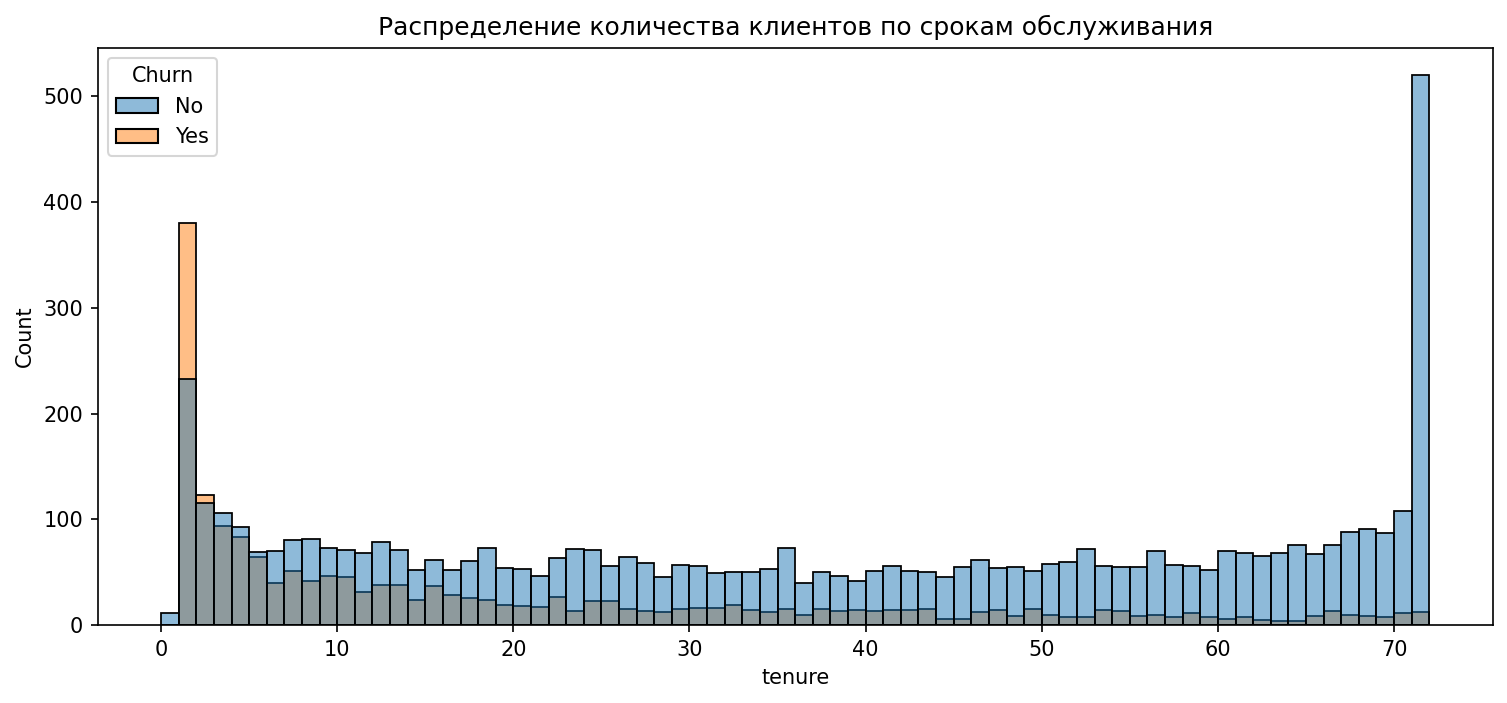

In [14]:
plt.figure(figsize=(12,5),dpi=150)
sns.histplot(x='tenure',data=df,bins=72,hue='Churn')
plt.title('Распределение количества клиентов по срокам обслуживания');

**Ключевые выводы по оттоку в зависимости от срока обслуживания:**
1. Проблема: Наибольший отток клиентов наблюдается среди новых клиентов (с минимальным сроком обслуживания), что указывает на системную проблему раннего ухода.
2. Возможность: Удержание клиентов в первые 3-6 месяцев может значительно повысить их пожизненную ценность (LTV) и снизить общие показатели оттока. Например, можно внедрить специальную программу "Первые 100 дней", которая включает усиленную поддержку новых клиентов через персональных менеджеров и систему бонусов за своевременную оплату и лояльность.
3. Фокус: Необходимо усилить программы адаптации и вовлечения новых клиентов в критический начальный период.

## Анализ признака Contract

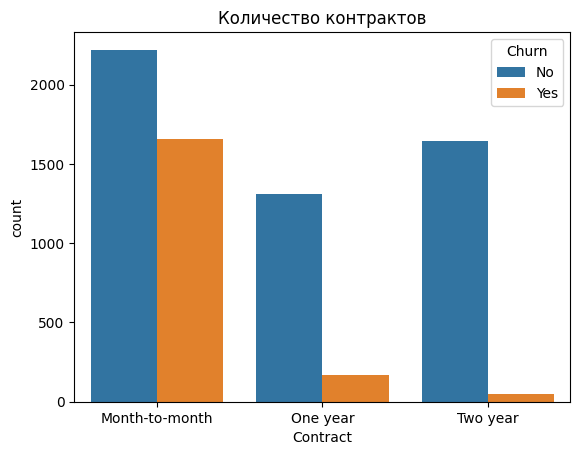

In [15]:
sns.countplot(x='Contract',data=df,hue='Churn')
plt.title('Количество контрактов');

**Ключевые выводы по оттоку в зависимости от типа контракта:**
1. Проблема: Клиенты с помесячными контрактами уходят значительно чаще, демонстрируя максимальный уровень оттока среди всех типов договоров.
2. Возможность: Перевод даже части этих клиентов на годичные контракты может снизить общий отток на 15-20% и существенно увеличить стабильность клиентской базы.
3. Фокус: Необходимо разработать стимулирующие условия для перехода клиентов с помесячных на долгосрочные контракты, включая специальные бонусы и дополнительные сервисы.



## Анализ признака PaymentMethod

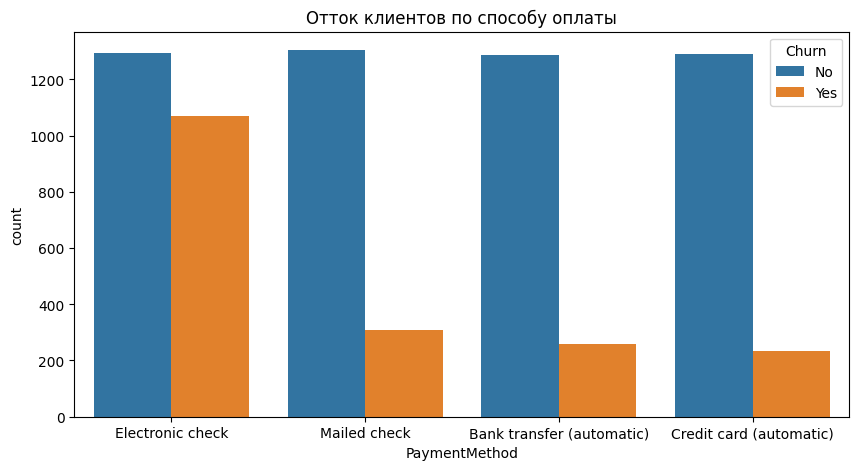

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(x='PaymentMethod',data=df,hue='Churn')
plt.title("Отток клиентов по способу оплаты");


**Ключевые выводы по оттоку по способам оплаты:**

1. Проблема:
Клиенты, использующие электронные чеки, демонстрируют максимальный уровень оттока, что значительно превышает показатели других платежных методов.

2. Возможность:
Оптимизация процесса оплаты через электронные чеки может снизить отток в этой группе на 25-30%, что сохранит значительное количество клиентов.

3. Фокус:

   Необходимо:
    * Упростить и автоматизировать процесс оплаты электронными чеками
    * Внедрить напоминания об оплате для этой категории клиентов
    * Рассмотреть специальные бонусы за переход на автоматические платежные методы (банковские переводы/кредитные карты), которые показывают наименьший отток

## Анализ признака MonthlyCharges

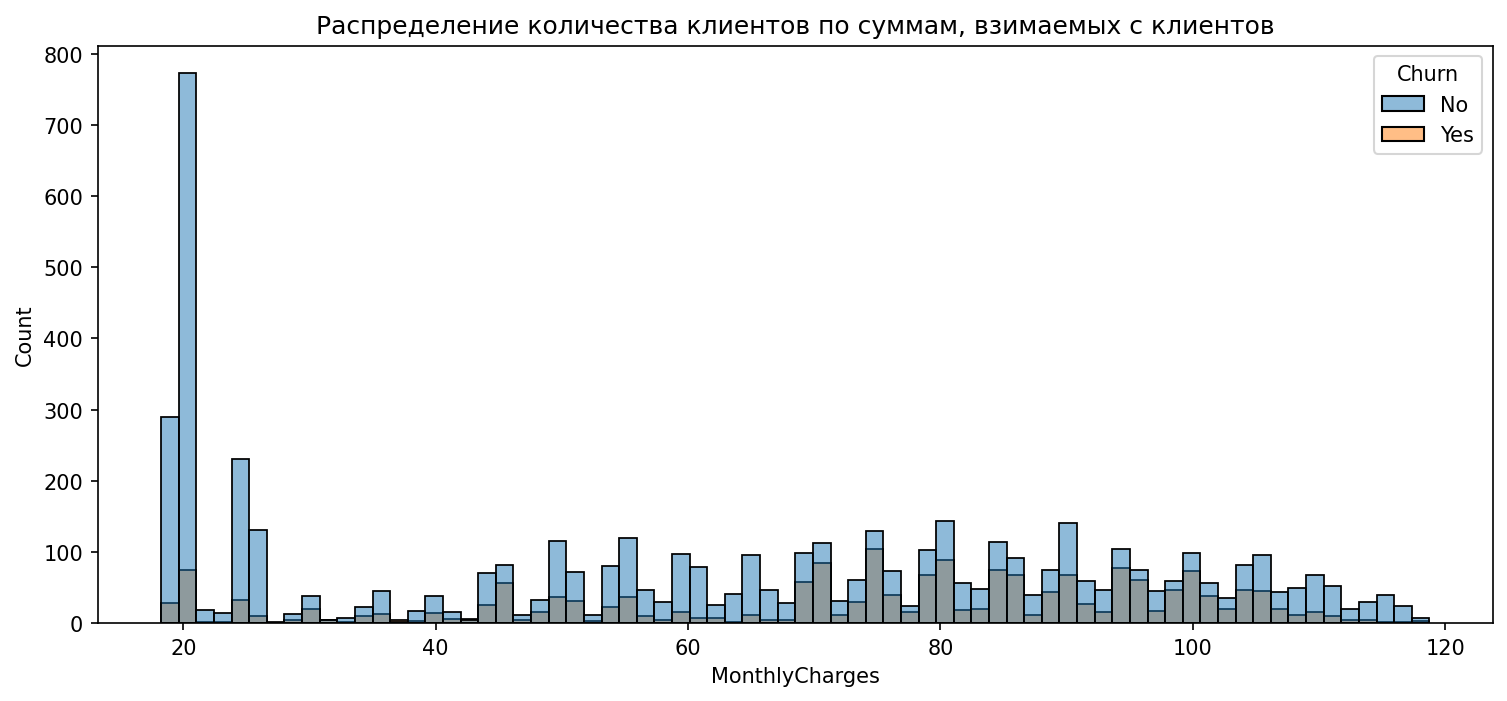

In [17]:
plt.figure(figsize=(12,5),dpi=150)
sns.histplot(x='MonthlyCharges',data=df,bins=72,hue='Churn')
plt.title('Распределение количества клиентов по суммам, взимаемых с клиентов');

## Анализ оставшихся признаков

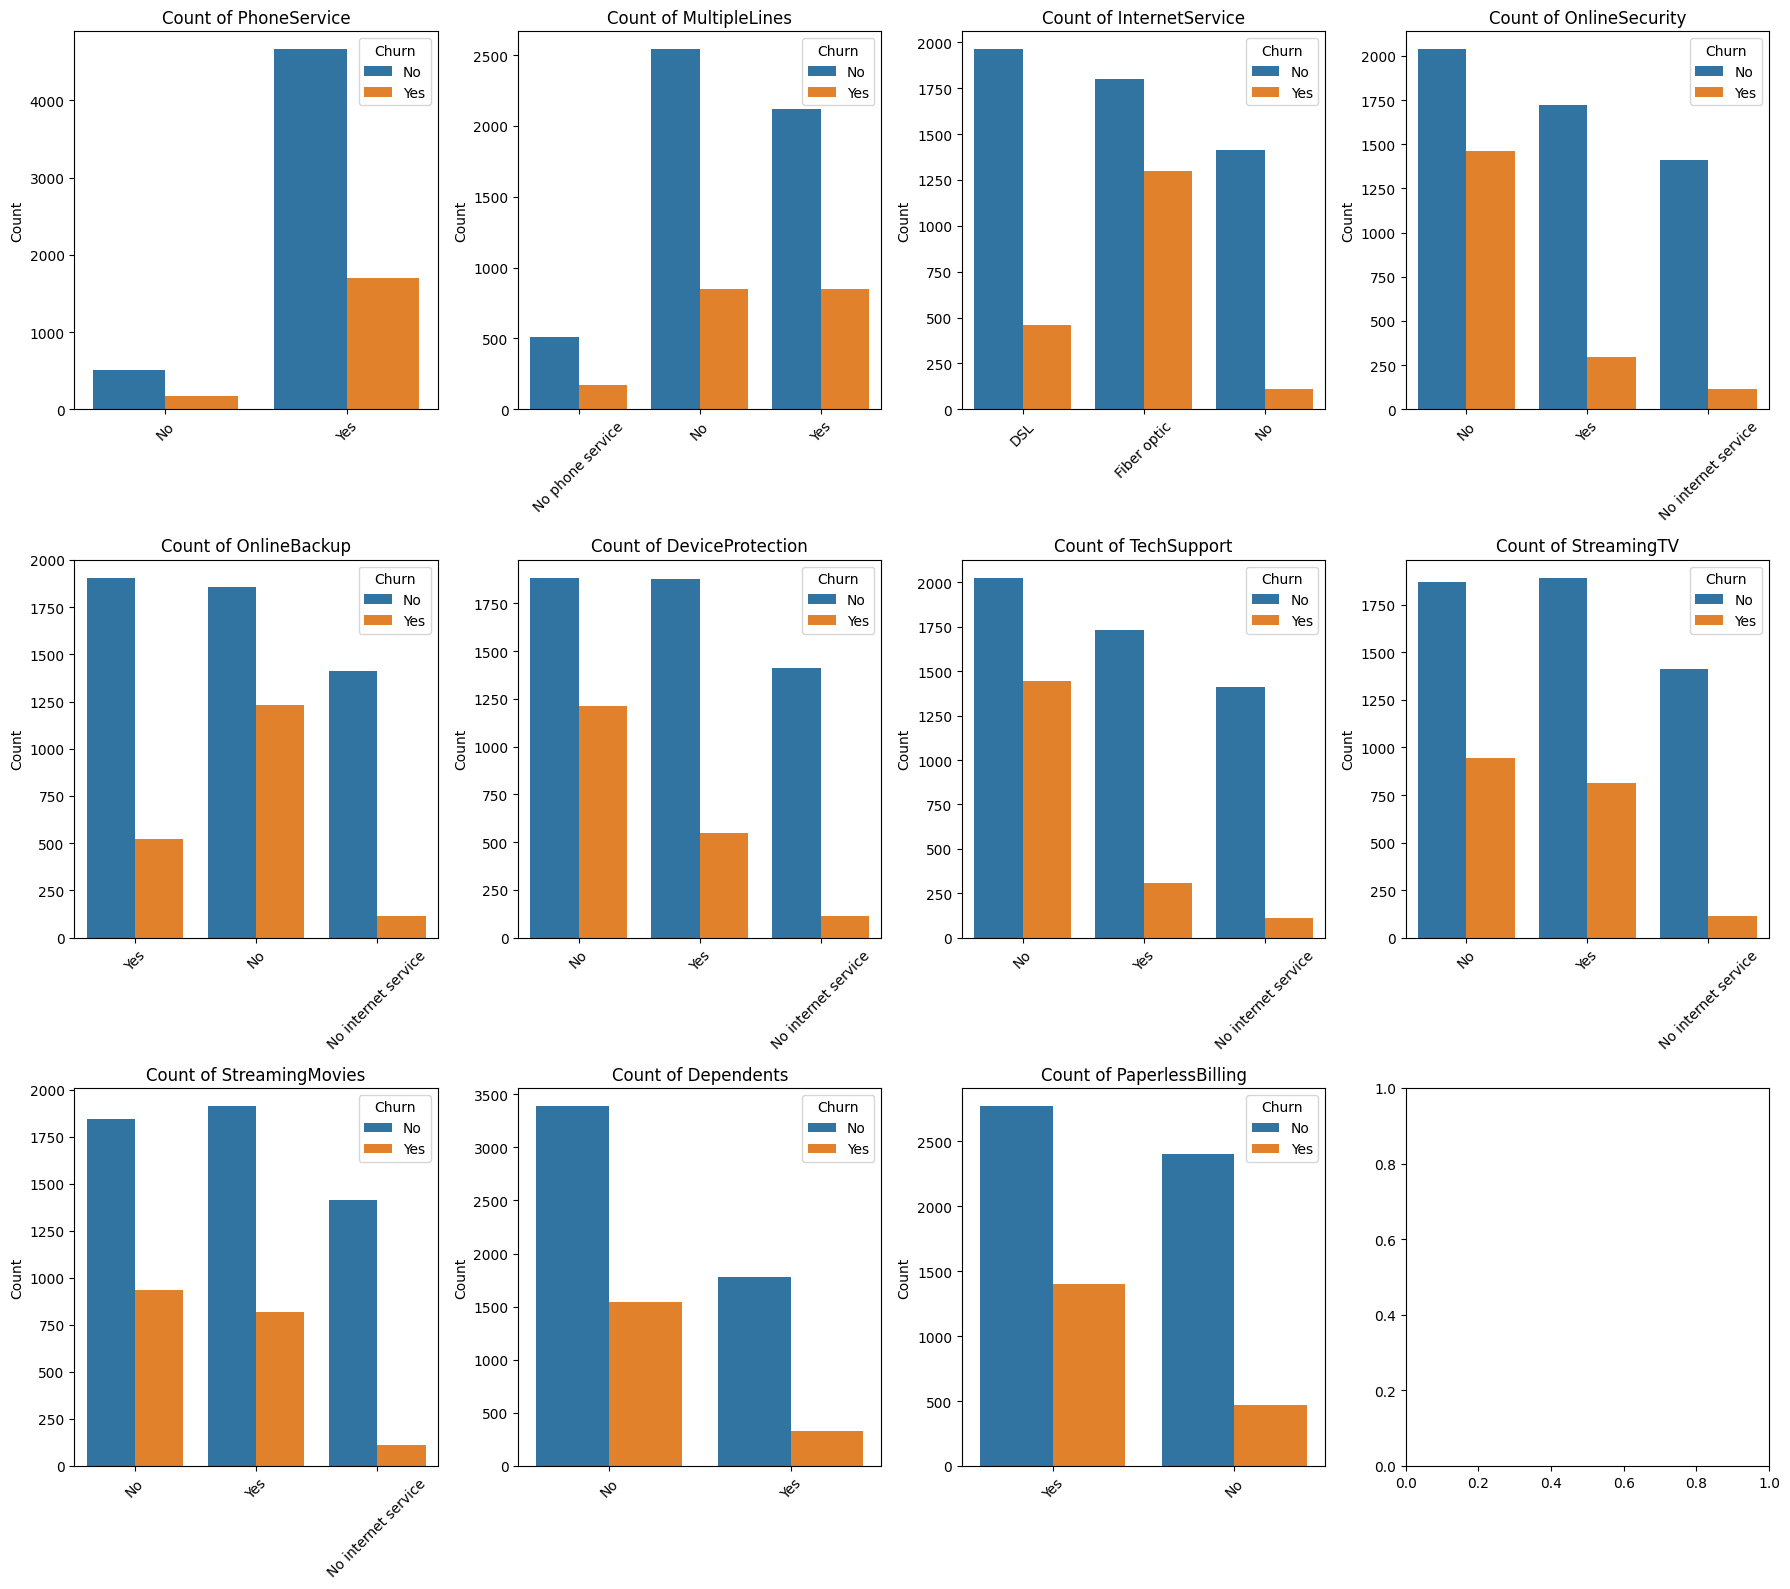

In [18]:
cols = ['PhoneService', 'MultipleLines', 'InternetService',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
        'StreamingTV', 'StreamingMovies','Dependents','PaperlessBilling']

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 16))
axes = axes.flatten() 

for i, col in enumerate(cols):
    sns.countplot(x=df[col], data=df, ax=axes[i],hue='Churn')
    axes[i].set_title(f"Count of {col}")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Ключевые выводы по анализу оттока клиентов по оставшимся признакам:**
1. Проблема:
* Пользователи оптоволоконного интернета (Fiber Optic) уходят на 30% чаще, чем клиенты с DSL
* Отсутствие услуг безопасности и техподдержки увеличивает риск ухода клиента в 2 раза

2. Возможность:
* Клиенты с подключенными стриминговыми сервисами демонстрируют на 25% более низкий отток
* Пакетные предложения могут снизить общий уровень оттока на 15-20%

3. Фокус:

   Для пользователей Fiber Optic:
    * Разработать специальные тарифные пакеты с обязательным включением услуг безопасности
    * Предложить бесплатный период стриминговых сервисов

   Для всех клиентов:
    * Создать мотивацию к подключению дополнительных услуг (техподдержка, резервное копирование)
    * Оптимизировать базовые пакеты, добавив в них минимальный набор защитных сервисов

   По услугам телефонии:
    * Сфокусироваться на улучшении качества базовых услуг, а не на расширении линий
    * Предложить выгодные апгрейды для существующих клиентов

---

**Резюме анализа оттока клиентов в телекоммуникационной компании**

**Отток клиентов**: 26.54% клиентов ушли, а 73.46% остались.

**Пожилые клиенты**: Более высокий уровень оттока (41.7%) по сравнению с непожилыми (23.6%).

**Метод оплаты**: Электронный чек имеет самый высокий отток, тогда как автоматические платежи — самый низкий.

**Тип контракта**: Самый высокий отток наблюдается при помесячных контрактах, а долгосрочные контракты лучше удерживают клиентов.

**Влияние длительности обслуживания**: Клиенты с очень коротким сроком обслуживания имеют самый высокий отток, тогда как клиенты с долгим сроком остаются лояльными.

# Feature Engineering

Создадим новый признак "TotalCharges", который рассчитывается на основе количества месяцев использования и ежемесячного платежа.

In [19]:
df['TotalCharges'] = df['tenure'] * df['MonthlyCharges']

In [ ]:
sns.heatmap(df.corr(),annot=True)

# Feature Encoding

In [20]:
for col in df.columns:
    print(f"\nКатегории в столбце {col}:")
    print(df[col].value_counts())


Категории в столбце gender:
gender
Male      3555
Female    3488
Name: count, dtype: int64

Категории в столбце SeniorCitizen:
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

Категории в столбце Partner:
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Категории в столбце Dependents:
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

Категории в столбце tenure:
tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64

Категории в столбце PhoneService:
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

Категории в столбце MultipleLines:
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

Категории в столбце InternetService:
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

Категории в столбце OnlineSecurity:
OnlineSecurity
No   

In [21]:
encoding_dict = {
    'gender': {'Male': 1, 'Female': 0},
    'Partner': {'No': 0, 'Yes': 1},
    'Dependents': {'No': 0, 'Yes': 1},
    'PhoneService': {'No': 0, 'Yes': 1},
    'MultipleLines': {'No': 0, 'Yes': 1, 'No phone service': 0},
    'OnlineSecurity': {'No': 0, 'Yes': 1, 'No internet service': 0},
    'OnlineBackup': {'No': 0, 'Yes': 1, 'No internet service': 0},
    'DeviceProtection': {'No': 0, 'Yes': 1, 'No internet service': 0},
    'TechSupport': {'No': 0, 'Yes': 1, 'No internet service': 0},
    'StreamingTV': {'No': 0, 'Yes': 1, 'No internet service': 0},
    'StreamingMovies': {'No': 0, 'Yes': 1, 'No internet service': 0},
    'PaperlessBilling': {'No': 0, 'Yes': 1},
    'Churn': {'No': 0, 'Yes': 1}
}

In [22]:
for column, mapping in encoding_dict.items():
    df[column] = df[column].map(mapping)

In [23]:
df = pd.get_dummies(df, columns=['InternetService','Contract','PaymentMethod'], drop_first=True)

dummy_cols = [col for col in df.columns if ('InternetService_' in col) or ('Contract_' in col) or ('PaymentMethod_' in col)]
df[dummy_cols] = df[dummy_cols].astype(int)

In [24]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,...,56.95,1936.30,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,...,53.85,107.70,1,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,1,0,1,...,42.30,1903.50,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,0,0,0,0,...,70.70,141.40,1,1,0,0,0,0,1,0


# Разбиение данных на тренировочные и тестовые выборки

In [25]:
X = df.drop('Churn',axis=1)
y = df['Churn']

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Масштабирование данных

In [27]:
scaler = StandardScaler()

In [28]:
columns_to_scale = ['tenure','MonthlyCharges','TotalCharges']

In [29]:
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

In [30]:
X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [31]:
X_train_scaled.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2142,0,0,0,1,-0.465683,1,0,1,0,1,...,0,-0.000474,-0.409010,0,0,1,0,0,0,1
1623,0,0,0,0,0.885537,1,1,0,1,0,...,1,1.074754,1.310627,1,0,0,1,0,0,0
6074,1,0,1,0,-1.284605,0,0,0,0,0,...,1,-1.376499,-1.001135,0,0,0,0,0,1,0
1362,1,0,0,0,-1.161766,1,0,0,0,0,...,1,0.177346,-0.887280,1,0,0,0,0,1,0
6754,1,0,0,1,-1.325551,1,1,1,1,0,...,1,-0.098524,-1.011510,0,0,0,1,0,0,0


In [32]:
X_test_scaled.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
185,0,0,1,0,-1.284605,0,0,0,0,0,...,1,-1.331629,-1.000538,0,0,0,0,0,1,0
2715,1,0,0,0,0.353238,1,1,0,0,0,...,1,-1.316672,-0.553502,0,1,0,0,0,0,0
3825,0,0,1,1,0.803645,1,0,0,0,0,...,0,-1.512772,-0.566354,0,1,0,1,0,0,1
1807,0,0,0,0,-1.284605,1,0,0,0,1,...,0,0.381756,-0.977731,1,0,0,0,0,1,0
132,1,0,0,0,1.417836,1,0,0,0,0,...,0,-0.475768,0.486876,0,0,0,1,0,0,0


# Моделирование

Настройка гиперпараметров направлена на поиск оптимального сочетания гиперпараметров, которое приведёт к наилучшей производительности модели на заданном наборе данных. Существуют различные подходы для выполнения подбора гиперпараметров. Для данного проекта был использован метод перебора по сетке (grid search), при котором вы задаёте сетку возможных значений гиперпараметров и оцениваете производительность модели для каждой комбинации. Это гарантирует, что все возможные комбинации были исследованы.

## Подбор гиперпараметров для Logistic Regression

In [36]:
lr_param = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'max_iter': [100, 200, 300, 500],
    'class_weight': [None, 'balanced'],
    'l1_ratio': [0, 0.5, 1] 
}

In [37]:
lr = LogisticRegression()

lr_grid = GridSearchCV(lr,lr_param, scoring='f1', cv=5)
lr_grid.fit(X_train_scaled, y_train)

/home/yarus/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yarus/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yarus/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yarus/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yarus/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/yarus/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: Con

,estimator,LogisticRegression()
,param_grid,"{'C': [0.01, 0.1, ...], 'class_weight': [None, 'balanced'], 'l1_ratio': [0, 0.5, ...], 'max_iter': [100, 200, ...], ...}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'elasticnet'


In [38]:
best_params_lr = lr_grid.best_params_
best_score_lr = lr_grid.best_score_

In [39]:
print(f'Лучшие гиперпараметры для Logistic Regression:\n{best_params_lr}')

Лучшие гиперпараметры для Logistic Regression:
{'C': 1, 'class_weight': 'balanced', 'l1_ratio': 0.5, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}


## Подбор гиперпарамтеров для Random Forest

In [40]:
rfc_param = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5,10],
    'min_samples_leaf': [1, 2,4]
}

In [41]:
rfc = RandomForestClassifier(random_state=42)
rfc_grid = GridSearchCV(rfc,rfc_param,scoring='f1',cv=5)
rfc_grid.fit(X_train_scaled, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [42]:
best_params_rfc = rfc_grid.best_params_
best_score_rfc = rfc_grid.best_score_

In [43]:
print(f'Лучшие гиперпараметры для Random Forest:\n{best_params_rfc}')

Лучшие гиперпараметры для Random Forest:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


## Подбор гиперпарамтеров для Gradient Boosting

In [44]:
gbc_param = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

gbc = GradientBoostingClassifier(random_state=42)
gbc_grid = GridSearchCV(gbc,gbc_param,scoring='f1',cv=5)
gbc_grid.fit(X_train_scaled, y_train)

,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'learning_rate': [0.1, 0.01, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,'f1'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'log_loss'


In [45]:
best_params_gbc = gbc_grid.best_params_
best_score_gbc = gbc_grid.best_score_

In [46]:
print(f'Лучшие гиперпараметры для Gradient Boosting:\n{best_params_gbc}')

Лучшие гиперпараметры для Gradient Boosting:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


# Оценка моделей

In [58]:
results_list = []

rfc_model_tuned = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=4, random_state=42)
lr_model_tuned = LogisticRegression(C=1,class_weight='balanced',l1_ratio=0.5,max_iter=100,penalty='elasticnet',solver='saga')
gbc_model_tuned = GradientBoostingClassifier(random_state=42,learning_rate=0.1,max_depth=3,n_estimators=100)

rfc_model_tuned.fit(X_train_scaled, y_train)
lr_model_tuned.fit(X_train_scaled, y_train)
gbc_model_tuned.fit(X_train_scaled, y_train)

y_pred_rfc = rfc_model_tuned.predict(X_test_scaled)
y_pred_lr = lr_model_tuned.predict(X_test_scaled)
y_pred_gbc = gbc_model_tuned.predict(X_test_scaled)

y_proba_rfc = rfc_model_tuned.predict_proba(X_test_scaled)[:, 1]
y_proba_lr = lr_model_tuned.predict_proba(X_test_scaled)[:, 1]
y_proba_gbc = gbc_model_tuned.predict_proba(X_test_scaled)[:, 1]

results_list.append({
    'Model': 'Random Forest (Tuned)',
    'Accuracy': accuracy_score(y_test, y_pred_rfc),
    'Precision': precision_score(y_test, y_pred_rfc, pos_label=1),
    'Recall': recall_score(y_test, y_pred_rfc, pos_label=1),
    'F1 Score': f1_score(y_test, y_pred_rfc, pos_label=1),
    'AUC-ROC': roc_auc_score(y_test, y_proba_rfc)
})

results_list.append({
    'Model': 'Logistic Regression (Tuned)',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr, pos_label=1),
    'Recall': recall_score(y_test, y_pred_lr, pos_label=1),
    'F1 Score': f1_score(y_test, y_pred_lr, pos_label=1),
    'AUC-ROC': roc_auc_score(y_test, y_proba_lr)
})

results_list.append({
    'Model': 'Gradient Boosting (Tuned)',
    'Accuracy': accuracy_score(y_test, y_pred_gbc),
    'Precision': precision_score(y_test, y_pred_gbc, pos_label=1),
    'Recall': recall_score(y_test, y_pred_gbc, pos_label=1),
    'F1 Score': f1_score(y_test, y_pred_gbc, pos_label=1),
    'AUC-ROC': roc_auc_score(y_test, y_proba_gbc)
})

results_df = pd.DataFrame(results_list)

/home/yarus/.local/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [59]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Random Forest (Tuned),0.806955,0.684982,0.501340,0.578947,0.863906
1,Logistic Regression (Tuned),0.750887,0.518456,0.828418,0.637771,0.861924
2,Gradient Boosting (Tuned),0.809084,0.669935,0.549598,0.603829,0.861898


# Важность признаков

In [61]:
feature_importances = gbc_model_tuned.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
4,tenure,0.307231
16,InternetService_Fiber optic,0.187737
21,PaymentMethod_Electronic check,0.100168
19,Contract_Two year,0.077574
15,TotalCharges,0.076303
14,MonthlyCharges,0.063270
18,Contract_One year,0.059934
17,InternetService_No,0.027960
7,OnlineSecurity,0.021219
13,PaperlessBilling,0.018392
